In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
import scipy.ndimage as ndimage
import pandas as pd

In [2]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import USCOUNTIES
import matplotlib.patheffects as pe

In [3]:
import cmocean
import xarray as xr
import numpy as np
import pathlib
import sys
import os

In [4]:
from dateparser import parse
from matplotlib import font_manager

### parses date

In [36]:
date = parse('today GMT')

date = date.strftime("%Y%m%d")

### opens dset

In [11]:
ds = xr.open_zarr("../data/ecmwf.zarr")

### convert from K to degrees F and C

In [12]:
temp = ((ds['t2m'] - 273.15)*1.8)+32

In [13]:
temp_c = ds['t2m'] - 273.15

### calculates minimum and maximum temperature over model run

In [62]:
# Extract the time values for the specified indices
timestamp_1 = temp.valid_time.isel(valid_time=0).dt.strftime("%b. %d").item()
timestamp_2 = temp.valid_time.isel(valid_time=52).dt.strftime("%b. %d").item()
timestamp_3 = temp.valid_time.isel(valid_time=40).dt.strftime("%b. %d").item()
timestamp_4 = temp.valid_time.isel(valid_time=64).dt.strftime("%b. %d").item()

# Print or use the formatted timestamps
print(f"Timestamp for temp[0]: {timestamp_1}")
print(f"Timestamp for temp[52]: {timestamp_2}")
print(f"Timestamp for temp[40]: {timestamp_3}")
print(f"Timestamp for temp[64]: {timestamp_4}")

Timestamp for temp[0]: Feb. 06
Timestamp for temp[52]: Feb. 13
Timestamp for temp[40]: Feb. 11
Timestamp for temp[64]: Feb. 16


In [16]:
# Select data from the first to the last time step
temp_full_range = temp.sel(valid_time=slice(None, None))

# Calculate the minimum and maximum across the selected time steps
temp_min_week = temp_full_range.min(dim="valid_time")
temp_max_week = temp_full_range.max(dim="valid_time")

In [17]:
# Extract the time values for the specified indices
timestamp_1 = temp.valid_time.isel(valid_time=0).dt.strftime("%b. %-d").item()
timestamp_2 = temp.valid_time.isel(valid_time=-1).dt.strftime("%b. %-d").item()

# Print or use the formatted timestamps
print(f"Timestamp for temp[0]: {timestamp_1}")
print(f"Timestamp for temp[-1]: {timestamp_2}")

Timestamp for temp[0]: Feb. 6
Timestamp for temp[-1]: Feb. 21


### sets time

In [18]:
conv = ds['valid_time'].dt.strftime('%Y-%m-%d %H')

In [19]:
conv = conv.values

In [20]:
step = ds['step']

In [21]:
step = step.values

In [22]:
step = step.astype('timedelta64[h]')

In [23]:
valid_time = ds['valid_time'].dt.round('H')

/opt/anaconda3/envs/climate/lib/python3.12/site-packages/xarray/core/accessor_dt.py:163: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  field_values = method(freq=freq).values


In [24]:
utc = valid_time.to_index()

In [25]:
local = utc.tz_localize('GMT').tz_convert('America/New_York')

In [26]:
local_time = local.strftime("%Y-%m-%d")

In [27]:
formatted_dates = pd.to_datetime(local_time).strftime("%b. %d")

### plots

In [28]:
lats = ds.variables['latitude'][:]  
lons = ds.variables['longitude'][:]

### wapo styling

In [29]:
font_path = '../fonts/Franklin/FranklinITCStd-Black.otf'
font_properties = font_manager.FontProperties(fname=font_path)

font_path2 = '../fonts/Franklin/FranklinITCStd-Bold.otf'
font_properties2 = font_manager.FontProperties(fname=font_path2)

font_path3 = '../fonts/Franklin/FranklinITCStd-Light.otf'
font_properties3 = font_manager.FontProperties(fname=font_path3, size=24)

In [30]:
state_centers = {
    "AK": (-152.0, 65.3), "AL": (-86.9, 32.8), "AZ": (-111.7, 34.1), "AR": (-92.3, 34.8),
    "CA": (-119.4, 36.7), "CO": (-105.5, 39.5), "CT": (-72.7, 41.6), "DC": (-77.0, 38.9),
    "DE": (-75.5, 38.9), "FL": (-81.6, 27.9), "GA": (-83.7, 33.3), "HI": (-157.8, 20.8),
    "IA": (-93.3, 41.8), "ID": (-114.5, 44.3), "IL": (-89.2, 40.0), "IN": (-86.3, 39.8),
    "KS": (-98.5, 38.5), "KY": (-84.3, 37.6), "LA": (-92.5, 31.1), "MA": (-71.9, 42.3),
    "MD": (-76.6, 39.4), "ME": (-69.3, 45.3), "MI": (-84.8, 43.3), "MN": (-94.4, 45.7),
    "MO": (-92.3, 38.5), "MS": (-89.7, 32.7), "MT": (-110.3, 46.8), "NC": (-79.0, 35.6),
    "ND": (-99.9, 47.5), "NE": (-98.9, 41.3), "NH": (-71.5, 43.4), "NJ": (-74.5, 40.5),
    "NM": (-106.2, 34.5), "NY": (-75.4, 42.5), "NV": (-116.4, 39.1), "OH": (-82.8, 40.4),
    "OK": (-97.5, 35.6), "OR": (-120.5, 44.0), "PA": (-77.3, 40.9), "RI": (-71.5, 41.7),
    "SC": (-81.0, 33.8), "SD": (-99.5, 44.3), "TN": (-86.5, 35.9), "TX": (-99.0, 31.0),
    "UT": (-111.7, 39.8), "VA": (-78.3, 37.5), "VT": (-72.6, 44.0), "WA": (-120.6, 47.4),
    "WI": (-89.6, 44.5), "WV": (-80.6, 38.6), "WY": (-107.3, 43.0)
}

# Eastern region
eastern_states = [
    "AL", "AR", "CT", "DC", "DE", "FL", "GA", "IL", "IN", "IA", "KY", "LA", "ME", "MA",
    "MD", "MI", "MN", "MS", "MO", "NC", "NH", "NJ", "NY", "OH", "PA", "RI", "SC", "TN",
    "VA", "VT", "WI", "WV"
]

# Western region
western_states = [
    "AZ", "CA", "CO", "ID", "KS", "MT", "NV", "NM", "ND", "NE", "OK", "OR", "SD", "TX",
    "UT", "WA", "WY"
]

# Central region
central_states = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "ID", "IL", "IN", "IA",
    "KS", "KY", "LA", "ME", "MA", "MD", "MI", "MN", "MS", "MO", "MT", "NC", "ND", "NE",
    "NV", "NH", "NJ", "NM", "NY", "OK", "OR", "OH", "PA", "RI", "SC", "SD", "TN", "TX",
    "UT", "VA", "VT", "WA", "WI", "WV", "WY"
]

# North America region
north_america_states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "ID", "IL", "IN",
    "IA", "KS", "KY", "LA", "ME", "MA", "MD", "MI", "MN", "MS", "MO", "MT", "NC", "ND",
    "NE", "NV", "NH", "NJ", "NM", "NY", "OK", "OR", "OH", "PA", "RI", "SC", "SD", "TN",
    "TX", "UT", "VA", "VT", "WA", "WI", "WV", "WY"
]

# Great Lakes region
great_lakes_states = [
    "CT", "IL", "IN", "ME", "MA", "MI", "NH", "NJ", "NY", "OH", "PA", "RI", "VT", "WI"
]

# Deep South region
deep_south_states = [
    "AL", "AR", "DC", "DE", "FL", "GA", "IL", "IN", "KS", "KY", "LA", "MD", "MS", "MO",
    "NC", "OH", "OK", "SC", "TN", "TX", "VA", "WV"
]

### temperature threshold - minimum, four categories

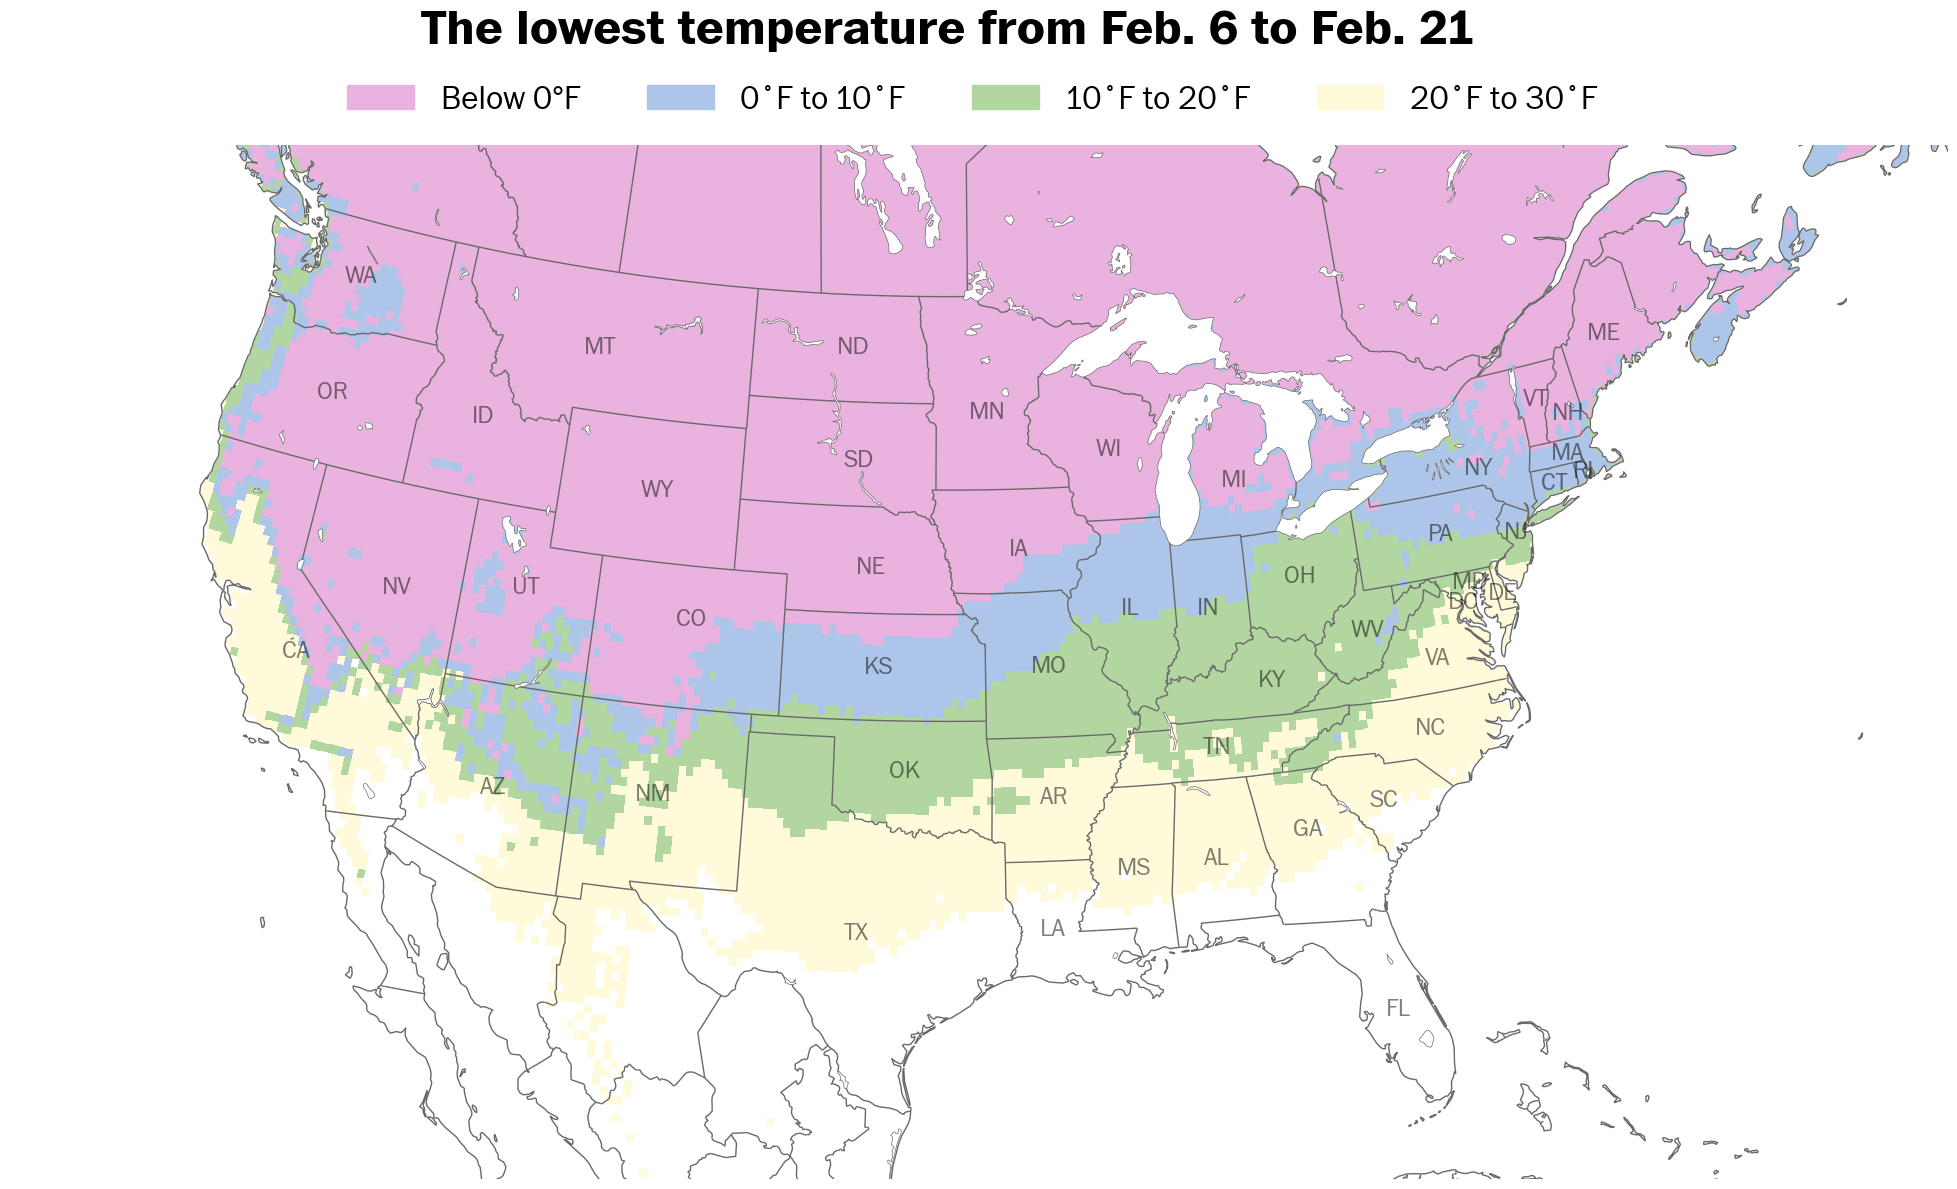

In [37]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties
import numpy as np

# Define thresholds and colors
thresholds = [0, 10, 20, 30]
colors = ['#EAB3DF', '#ACC5E8', '#B2D6A0', '#FFFBDA', '#FFFFFF']  # White added for >40°F
cmap = ListedColormap(colors)

# Classification based on thresholds
classification = np.zeros_like(temp_min_week)
classification = np.where(temp_min_week > thresholds[3], 4, classification)  # Above 40°F -> Category 4 (white)
classification = np.where(temp_min_week < thresholds[3], 3, classification)  # Below 40°F -> Category 3
classification = np.where(temp_min_week < thresholds[2], 2, classification)  # Below 30°F -> Category 2
classification = np.where(temp_min_week < thresholds[1], 1, classification)  # Below 20°F -> Category 1
classification = np.where(temp_min_week < thresholds[0], 0, classification)  # Below 10°F -> Category 0

# Set projection type and region
region = "central"  # Change to 'eastern' or 'western' as needed
zoom_options = {
    "central": [-125, -65, 24, 50],
    "western": [-125, -95, 25, 50],
    "eastern": [-95, -65, 25, 50],
}

# Set the projection and extent
proj = ccrs.AlbersEqualArea(
    central_longitude=-96,
    central_latitude=23,
    standard_parallels=(29.5, 45.5)
)
fig, ax = plt.subplots(figsize=(25, 15), subplot_kw={"projection": proj})
ax.set_extent(zoom_options[region], crs=ccrs.PlateCarree())

# Add map features
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none'
)
# Add map features with improved settings
ax.add_feature(cfeature.LAND, color='#F5F5F5', edgecolor='k', alpha=0.8)
ax.coastlines(resolution='50m', color='dimgray', linewidth=1, zorder=104)
ax.add_feature(cfeature.BORDERS, edgecolor='dimgray')
lakes = cfeature.NaturalEarthFeature(
    'physical', 'lakes', '50m',
    edgecolor='dimgray', facecolor='white'
)
ax.add_feature(lakes, alpha=1, linewidth=0.5, zorder=100)
ax.add_feature(states_provinces, edgecolor='dimgray')
ax.add_feature(cfeature.OCEAN, color='#FFFFFF', alpha=1, zorder=103)

# Plot data
data = ax.pcolormesh(
    lons, lats, classification,
    cmap=cmap,
    transform=ccrs.PlateCarree()
)

# Add color legend
legend_labels = {
    "0": "Below 0°F",
    "1": "0˚F to 10˚F",
    "2": "10˚F to 20˚F",
    "3": "20˚F to 30˚F"
}
patches = [
    Patch(color=colors[0], label=legend_labels["0"]),
    Patch(color=colors[1], label=legend_labels["1"]),
    Patch(color=colors[2], label=legend_labels["2"]),
    Patch(color=colors[3], label=legend_labels["3"])
]

legend = fig.legend(
    handles=patches,
    loc='lower center',
    facecolor="white",
    prop=font_properties3,  # Apply font properties to legend
    frameon=False,
    edgecolor='k',
    fancybox=False,
    ncol=4,
    bbox_to_anchor=(0.51, 0.84)  # Move the legend closer with a negative y-anchor value
)

# Add title with font properties
plt.suptitle(
    f'The lowest temperature from {timestamp_1} to {timestamp_2}',
    fontsize=36, fontproperties=font_properties2, y=0.93, x=0.50
)

fig.patch.set_facecolor('white')

# Remove the black border surrounding the map
for spine in ax.spines.values():
    spine.set_visible(False)

# Add state labels (abbreviations)
for state, (lon, lat) in state_centers.items():
    # Determine which states to plot based on the region
    if region == "central" and state in central_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)
    elif region == "eastern" and state in eastern_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)
    elif region == "western" and state in western_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)
    elif region == "great_lakes" and state in great_lakes_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)

# Save and display the plot
save_path = f"../imagery/{date}/min_temps-four_categories.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

plt.savefig(save_path, facecolor=fig.get_facecolor(), dpi=100, bbox_inches="tight")

plt.show()


### temperature threshold - minimum, five categories

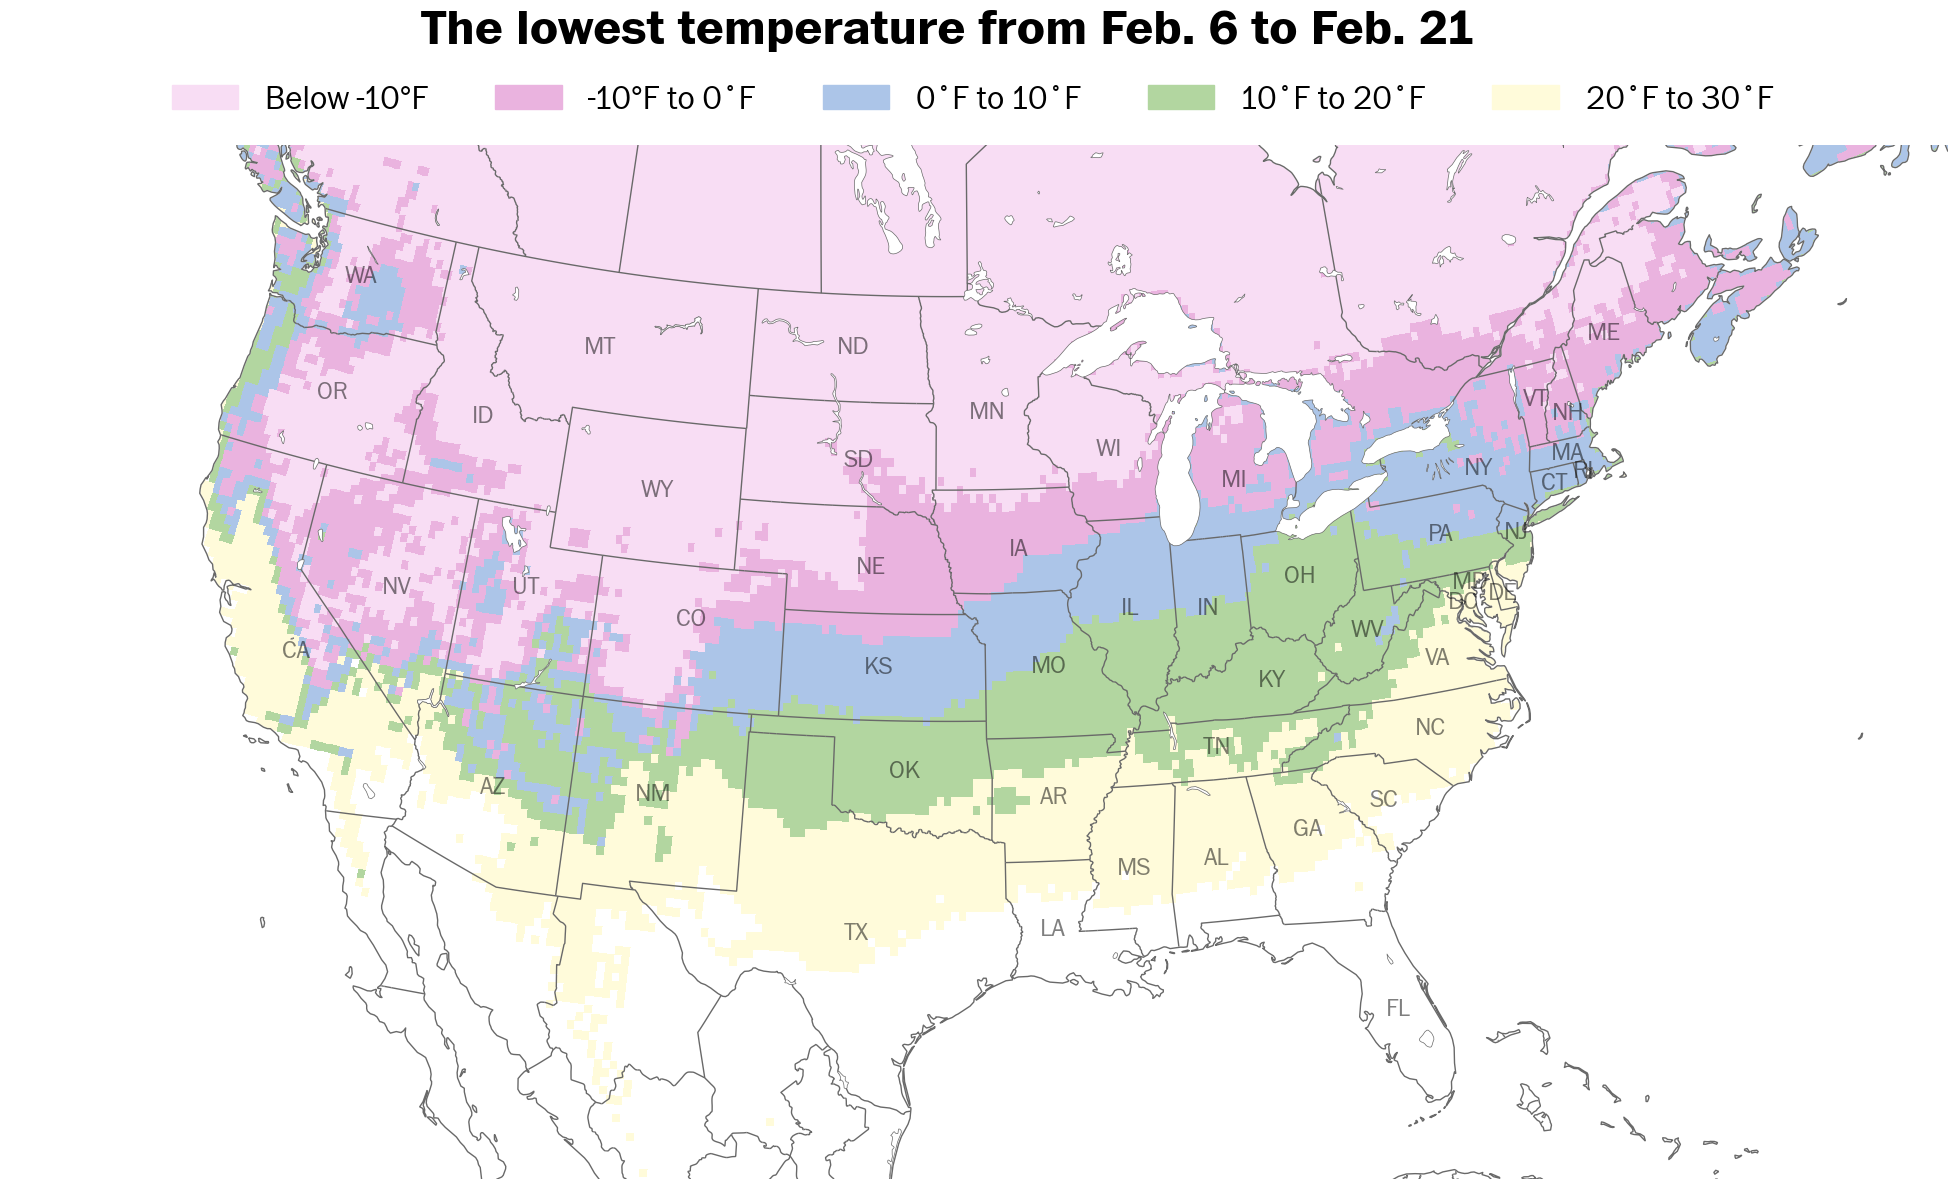

In [38]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties
import numpy as np

# Define thresholds and colors
thresholds = [-10, 0, 10, 20, 30]
colors = ['#f8ddf4', '#EAB3DF', '#ACC5E8', '#B2D6A0', '#FFFBDA', '#FFFFFF']  # White added for >40°F
cmap = ListedColormap(colors)

# Classification based on thresholds
classification = np.zeros_like(temp_min_week)

# Apply classification logic correctly for ranges
classification = np.where(temp_min_week < thresholds[0], 0, classification)  # Below -10°F -> Category 0
classification = np.where((temp_min_week >= thresholds[0]) & (temp_min_week < thresholds[1]), 1, classification)  # -10 to 0°F -> Category 1
classification = np.where((temp_min_week >= thresholds[1]) & (temp_min_week < thresholds[2]), 2, classification)  # 0 to 10°F -> Category 2
classification = np.where((temp_min_week >= thresholds[2]) & (temp_min_week < thresholds[3]), 3, classification)  # 10 to 20°F -> Category 3
classification = np.where((temp_min_week >= thresholds[3]) & (temp_min_week < thresholds[4]), 4, classification)  # 20 to 30°F -> Category 4
classification = np.where(temp_min_week >= thresholds[4], 5, classification)  # 30°F and above -> Category 5

# Set projection type and region
region = "central"  # Change to 'eastern' or 'western' as needed
zoom_options = {
    "central": [-125, -65, 24, 50],
    "western": [-125, -95, 25, 50],
    "eastern": [-95, -65, 25, 50],
}

# Set the projection and extent
proj = ccrs.AlbersEqualArea(
    central_longitude=-96,
    central_latitude=23,
    standard_parallels=(29.5, 45.5)
)
fig, ax = plt.subplots(figsize=(25, 15), subplot_kw={"projection": proj})
ax.set_extent(zoom_options[region], crs=ccrs.PlateCarree())

# Add map features
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none'
)
# Add map features with improved settings
ax.add_feature(cfeature.LAND, color='#F5F5F5', edgecolor='k', alpha=0.8)
ax.coastlines(resolution='50m', color='dimgray', linewidth=1, zorder=104)
ax.add_feature(cfeature.BORDERS, edgecolor='dimgray')
lakes = cfeature.NaturalEarthFeature(
    'physical', 'lakes', '50m',
    edgecolor='dimgray', facecolor='white'
)
ax.add_feature(lakes, alpha=1, linewidth=0.5, zorder=100)
ax.add_feature(states_provinces, edgecolor='dimgray')
ax.add_feature(cfeature.OCEAN, color='#FFFFFF', alpha=1, zorder=103)

# Plot data
data = ax.pcolormesh(
    lons, lats, classification,
    cmap=cmap,
    transform=ccrs.PlateCarree()
)

# Add color legend
legend_labels = {
    "0": "Below -10°F",
    "1": "-10°F to 0˚F",
    "2": "0˚F to 10˚F",
    "3": "10˚F to 20˚F",
    "4": "20˚F to 30˚F"
}
patches = [
    Patch(color=colors[0], label=legend_labels["0"]),
    Patch(color=colors[1], label=legend_labels["1"]),
    Patch(color=colors[2], label=legend_labels["2"]),
    Patch(color=colors[3], label=legend_labels["3"]),
    Patch(color=colors[4], label=legend_labels["4"])
]

legend = fig.legend(
    handles=patches,
    loc='lower center',
    facecolor="white",
    prop=font_properties3,  # Apply font properties to legend
    frameon=False,
    edgecolor='k',
    fancybox=False,
    ncol=5,
    bbox_to_anchor=(0.51, 0.84)  # Move the legend closer with a negative y-anchor value
)

# Add title with font properties
plt.suptitle(
    f'The lowest temperature from {timestamp_1} to {timestamp_2}',
    fontsize=36, fontproperties=font_properties2, y=0.93, x=0.50
)

fig.patch.set_facecolor('white')

# Remove the black border surrounding the map
for spine in ax.spines.values():
    spine.set_visible(False)

# Add state labels (abbreviations)
for state, (lon, lat) in state_centers.items():
    # Determine which states to plot based on the region
    if region == "central" and state in central_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)
    elif region == "eastern" and state in eastern_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)
    elif region == "western" and state in western_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)
    elif region == "great_lakes" and state in great_lakes_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)

# Save and display the plot
save_path = f"../imagery/{date}/min_temps-five_categories.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

plt.savefig(save_path, facecolor=fig.get_facecolor(), dpi=100, bbox_inches="tight")

plt.show()


### temperature threshold - maximum, four categories

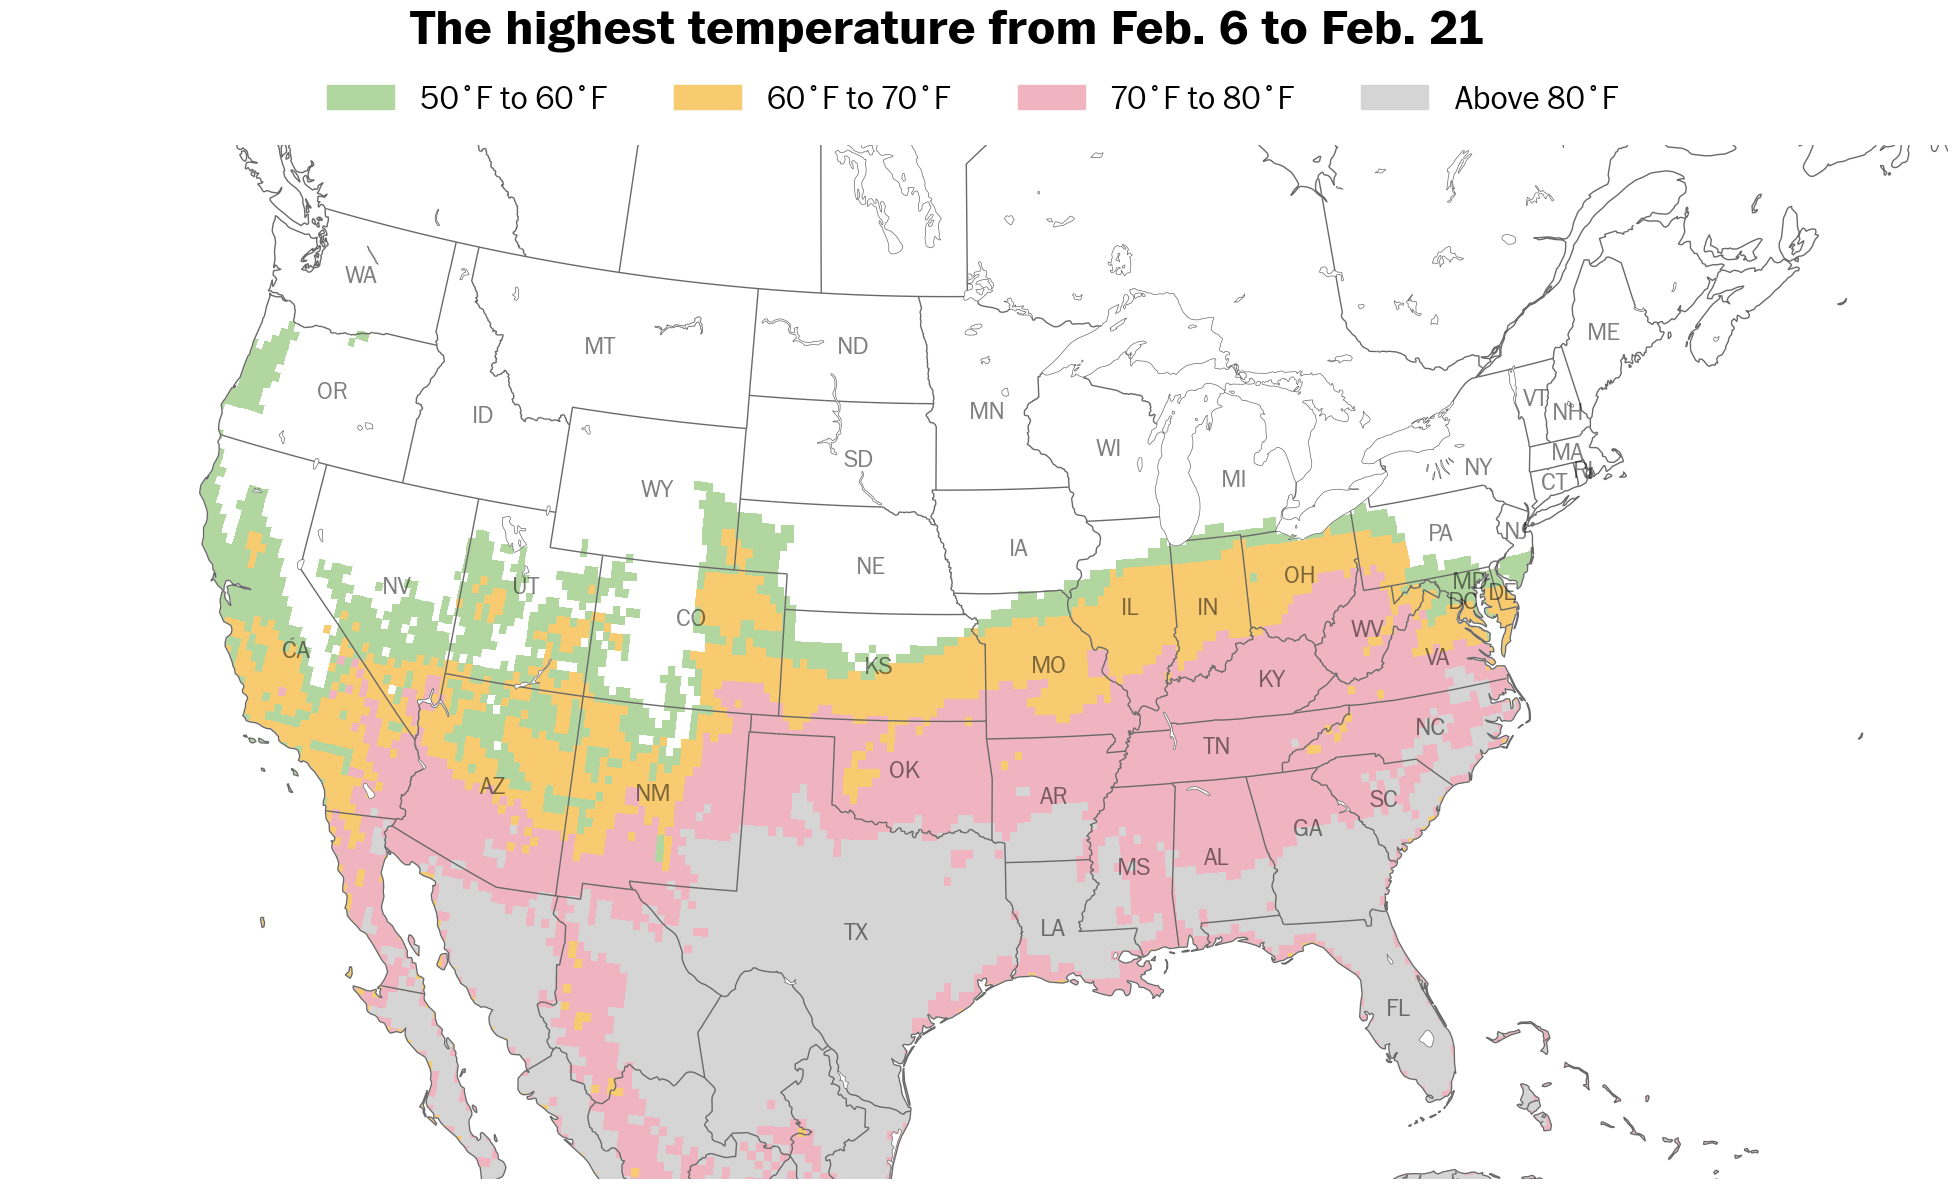

In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties
import numpy as np

# Define thresholds and colors
thresholds = [50, 60, 70, 80]
colors = ['#FFFFFF', '#b2d6a0', '#f8cb70', '#f0b4c0', '#d5d5d5']  # White for values below 50°F
cmap = ListedColormap(colors)

# Classification based on thresholds
classification = np.zeros_like(temp_max_week)

# Apply thresholds and assign categories
classification = np.where(temp_max_week >= thresholds[3], 4, classification)  # ≥ 80°F -> Category 4
classification = np.where((temp_max_week >= thresholds[2]) & (temp_max_week < thresholds[3]), 3, classification)  # 70–79°F -> Category 3
classification = np.where((temp_max_week >= thresholds[1]) & (temp_max_week < thresholds[2]), 2, classification)  # 60–69°F -> Category 2
classification = np.where((temp_max_week >= thresholds[0]) & (temp_max_week < thresholds[1]), 1, classification)  # 50–59°F -> Category 1
classification = np.where(temp_max_week < thresholds[0], 0, classification)  # < 50°F -> Category 0 (white)

# Set projection type and region
region = "central"  # Change to 'eastern' or 'western' as needed
zoom_options = {
    "central": [-125, -65, 24, 50],
    "western": [-125, -95, 25, 50],
    "eastern": [-95, -65, 25, 50],
}

# Set the projection and extent
proj = ccrs.AlbersEqualArea(
    central_longitude=-96,
    central_latitude=23,
    standard_parallels=(29.5, 45.5)
)
fig, ax = plt.subplots(figsize=(25, 15), subplot_kw={"projection": proj})
ax.set_extent(zoom_options[region], crs=ccrs.PlateCarree())

# Add map features
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none'
)
# Add map features with improved settings
ax.add_feature(cfeature.LAND, color='#F5F5F5', edgecolor='k', alpha=0.8)
ax.coastlines(resolution='50m', color='dimgray', linewidth=1, zorder=104)
ax.add_feature(cfeature.BORDERS, edgecolor='dimgray')
lakes = cfeature.NaturalEarthFeature(
    'physical', 'lakes', '50m',
    edgecolor='dimgray', facecolor='white'
)
ax.add_feature(lakes, alpha=1, linewidth=0.5, zorder=100)
ax.add_feature(states_provinces, edgecolor='dimgray')
ax.add_feature(cfeature.OCEAN, color='#FFFFFF', alpha=1, zorder=103)

# Plot data
data = ax.pcolormesh(
    lons, lats, classification,
    cmap=cmap,
    transform=ccrs.PlateCarree()
)

# Add color legend
legend_labels = {
    "0": "Below 50˚F",
    "1": "50˚F to 60˚F",
    "2": "60˚F to 70˚F",
    "3": "70˚F to 80˚F",
    "4": "Above 80˚F"
}

patches = [
    # Patch(color=colors[0], label=legend_labels["0"]),  # Below 50°F
    Patch(color=colors[1], label=legend_labels["1"]),  # 50–60°F
    Patch(color=colors[2], label=legend_labels["2"]),  # 60–70°F
    Patch(color=colors[3], label=legend_labels["3"]),  # 70–80°F
    Patch(color=colors[4], label=legend_labels["4"])   # Above 80°F
]

legend = fig.legend(
    handles=patches,
    loc='lower center',
    facecolor="white",
    prop=font_properties3,  # Apply font properties to legend
    frameon=False,
    edgecolor='k',
    fancybox=False,
    ncol=4,
    bbox_to_anchor=(0.51, 0.84)  # Move the legend closer with a negative y-anchor value
)

# Add title with font properties
plt.suptitle(
    f'The highest temperature from {timestamp_1} to {timestamp_2}',
    fontsize=36, fontproperties=font_properties2, y=0.93, x=0.50
)

fig.patch.set_facecolor('white')

# Remove the black border surrounding the map
for spine in ax.spines.values():
    spine.set_visible(False)

# Add state labels (abbreviations)
for state, (lon, lat) in state_centers.items():
    # Determine which states to plot based on the region
    if region == "central" and state in central_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)
    elif region == "eastern" and state in eastern_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)
    elif region == "western" and state in western_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)
    elif region == "great_lakes" and state in great_lakes_states:
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)

# Save and display the plot
save_path = f"../imagery/{date}/max_temps-four_categories.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

plt.savefig(save_path, facecolor=fig.get_facecolor(), dpi=100, bbox_inches="tight")

plt.show()


### shorts weather

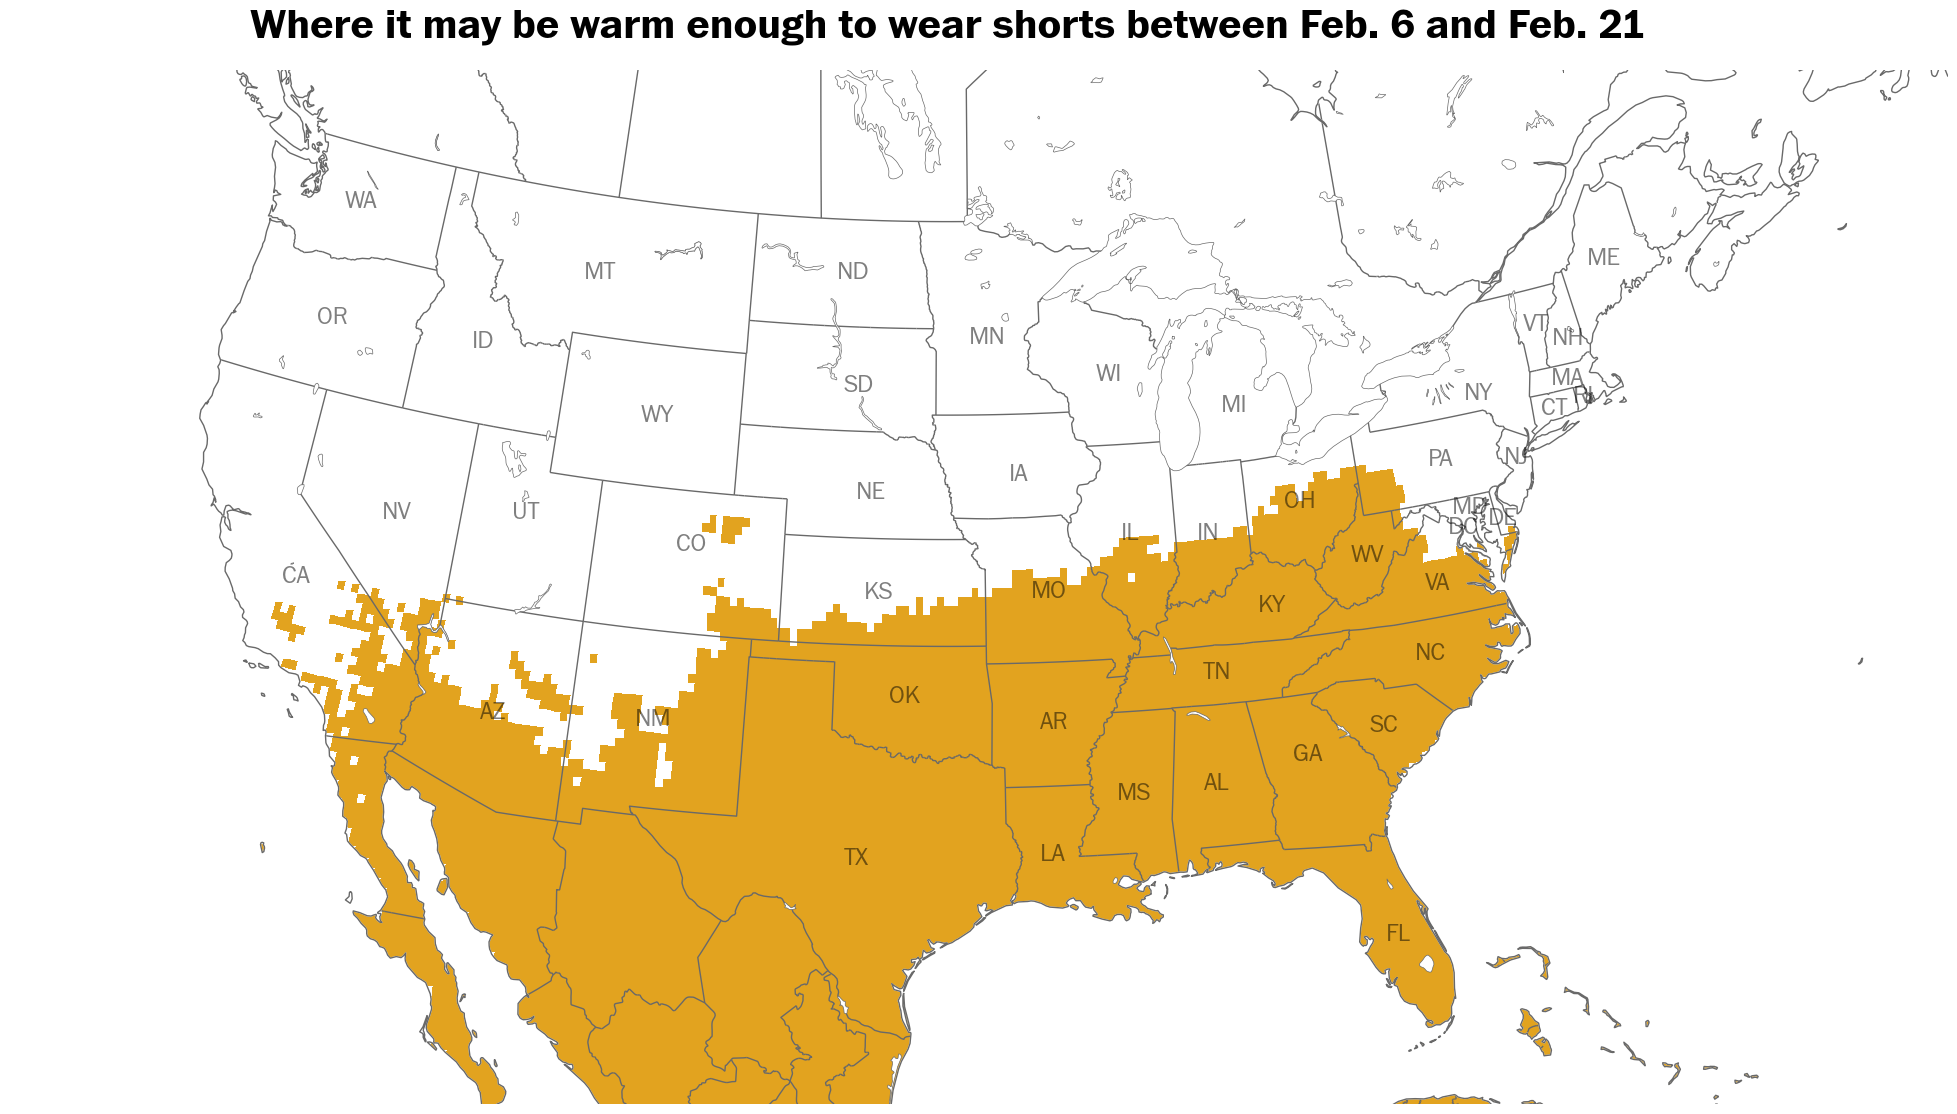

In [40]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import numpy as np

# Define threshold and color
threshold = 66
highlight_color = '#e2a31f'  # Single solid color for >= 70°F
cmap = ListedColormap(["white", highlight_color])

# Classification: 0 for below 70°F, 1 for 70°F and above
classification = np.where(temp_max_week >= threshold, 1, 0)

# Set projection type and region
region = "central"  # Change to 'eastern' or 'western' as needed
zoom_options = {
    "central": [-125, -65, 24, 50],
    "western": [-125, -95, 25, 50],
    "eastern": [-95, -65, 25, 50],
}

# Set the projection and extent
proj = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=23, standard_parallels=(29.5, 45.5))
fig, ax = plt.subplots(figsize=(25, 15), subplot_kw={"projection": proj})
ax.set_extent(zoom_options[region], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, color='#F5F5F5', edgecolor='k', alpha=0.8)
ax.coastlines(resolution='50m', color='dimgray', linewidth=1, zorder=104)
ax.add_feature(cfeature.BORDERS, edgecolor='dimgray')
lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='dimgray', facecolor='white')
ax.add_feature(lakes, alpha=1, linewidth=0.5, zorder=100)
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='10m', facecolor='none'), edgecolor='dimgray')
ax.add_feature(cfeature.OCEAN, color='#FFFFFF', alpha=1, zorder=103)

# Plot data
ax.pcolormesh(lons, lats, classification, cmap=cmap, transform=ccrs.PlateCarree())

# Add title with font properties
plt.suptitle(f'Where it may be warm enough to wear shorts between {timestamp_1} and {timestamp_2}',
             fontsize=30, fontproperties=font_properties2, y=0.88, x=0.5)

fig.patch.set_facecolor('white')

# Remove the black border surrounding the map
for spine in ax.spines.values():
    spine.set_visible(False)

# Add state labels (abbreviations)
for state, (lon, lat) in state_centers.items():
    if (region == "central" and state in central_states) or \
       (region == "eastern" and state in eastern_states) or \
       (region == "western" and state in western_states) or \
       (region == "great_lakes" and state in great_lakes_states):
        ax.text(lon, lat, state, transform=ccrs.PlateCarree(), fontproperties=font_properties3,
                fontsize=18, color='k', ha='center', va='center', zorder=105, alpha=0.5)

# Save and display the plot
save_path = f"../imagery/{date}/shorts_weather.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

plt.savefig(save_path, facecolor=fig.get_facecolor(), dpi=100, bbox_inches="tight")

plt.show()
